In [1]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers.optimization import AdamW
import matplotlib.pyplot as plt

In [2]:
from CONFIG import *
from dataset import Dataset
from modeling_strats import Strats
from modeling_gru import GRU_TS
from modeling_grud import GRUD_TS
from modeling_test import STraTS_new
from utils import set_all_seeds,parse_args,set_output_dir, save_results, Logger
from evaluator import Evaluator
from argparse import Namespace

In [3]:
model_mapping = {'strats':Strats, 'gru':GRU_TS, 'grud':GRUD_TS, 'new':STraTS_new}

## GRU

In [6]:
def train_gru(hid_dim, dropout, lr, max_epochs, gradient_accumulation_steps):
    parser = parse_args(model_type = 'gru', hid_dim =hid_dim,dropout = dropout, lr = lr, max_epochs = max_epochs, gradient_accumulation_steps = gradient_accumulation_steps)
    args, _ = parser.parse_known_args()
    set_all_seeds(args.seed+int(args.run.split('o')[0]))
    set_output_dir(args)
    args.logger = Logger(args.output_dir, 'log.txt')
    args.logger.write('\n'+str(args))
    dataset = Dataset(args)
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_mapping[args.model_type](args)
    model.to(args.device)
    results = {'epoch':[],'train_auroc':[],'val_auroc':[],'test_auroc':[]}

    #trainning
    num_train = len(dataset.splits['train'])
    args.logger.write('\nSize of training data: ' + str(num_train))
    num_batches_per_epoch = num_train/args.train_batch_size
    args.logger.write('\nNo. of training batches per epoch: '
                        +str(num_batches_per_epoch))
    args.max_steps = int(round(num_batches_per_epoch)*args.max_epochs)
    args.logger.write('\nMax steps: ' + str(num_batches_per_epoch))

    if args.validate_every is None:
        args.validate_every = int(np.ceil(num_batches_per_epoch)) #validate after each batch

    num_steps = 0
    optimizer = AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=args.lr)
    train_bar = tqdm(range(args.max_steps))
    evaluator = Evaluator(args)

    #before training, calculate metrics
    if args.validate_after<0:
        res_val = evaluator.evaluate(model, dataset, 'val',  train_step=-1)
        res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=-1)
        res_test = evaluator.evaluate(model, dataset, 'test', train_step=-1)
        results['train_auroc'].append(res_train['auroc'])
        results['val_auroc'].append(res_val['auroc'])
        results['test_auroc'].append(res_test['auroc'])

    #training
    model.train()
    for step in train_bar:
        data_batch = dataset.get_batch()
        data_batch = {k:v.to(args.device) for k,v in data_batch.items()}

        loss = model(**data_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.3)
        if (step+1)%args.gradient_accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()

        num_steps += 1

        # run validatation
        if (num_steps>=args.validate_after) and (num_steps%args.validate_every==0):
            # get metrics on test and validation splits
            res_val = evaluator.evaluate(model, dataset, 'val', train_step=step)
            res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=step)
            res_test = evaluator.evaluate(model, dataset, 'test', train_step=step)
            results['train_auroc'].append(res_train['auroc'])
            results['val_auroc'].append(res_val['auroc'])
            results['test_auroc'].append(res_test['auroc'])
            model.train(True)

    results['epoch'] =list(range(0,args.max_epochs+1))
    save_results(args, results)



16/10/2024 13:52:28 >> Namespace(dataset='mimic_iii', train_frac=0.7, run='1o10', model_type='gru', max_obs=880, hid_dim=50, num_layers=2, num_heads=4, dropout=0.2, attention_dropout=0.2, kernel_size=4, r=24, M=12, max_timesteps=880, num_ts_feat=51, num_demo_feat=3, hours_look_ahead=24, ref_points=24, pretrain=0, output_dir='../outputs/mimic_iii/gru,hid_dim:50,dropout:0.2,lr:0.0001,gradient_accumulation_steps:8,max_epochs:1|train_frac:0.7|run:1o10', output_dir_prefix='', seed=2024, max_epochs=1, patience=10, lr=0.0001, train_batch_size=16, gradient_accumulation_steps=8, eval_batch_size=16, print_train_loss_every=100, validate_after=-1, validate_every=None, load_ckpt_path=None, logger=<utils.Logger object at 0x153373fa0>)

16/10/2024 13:52:30 >> Preparing dataset mimic_iii
16/10/2024 13:52:30 >> Removing variables not in training set: ['.3% normal Saline']
16/10/2024 13:52:30 >> # train, val, test TS: [3918, 1120, 800]
16/10/2024 13:52:30 >> pos class weight: 3.934508816120907
16/10/20

12199it [00:00, 1851102.15it/s]


16/10/2024 13:52:31 >> # intervals: 24


941654it [00:00, 1767873.47it/s]
/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/zhiwenxu/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



16/10/2024 13:52:32 >> Size of training data: 3918

16/10/2024 13:52:32 >> No. of training batches per epoch: 244.875

16/10/2024 13:52:32 >> Max steps: 244.875


  0%|          | 0/245 [00:00<?, ?it/s]


16/10/2024 13:52:32 >> Evaluating on split = val


running forward pass: 100%|██████████| 70/70 [00:00<00:00, 990.15it/s]


16/10/2024 13:52:32 >> Result on val split at train step -1: {'auroc': 0.43768591547169056, 'auprc': 0.1673716434041449, 'minrp': 0.19784172661870503}

16/10/2024 13:52:32 >> Evaluating on split = eval_train


running forward pass: 100%|██████████| 125/125 [00:00<00:00, 742.05it/s]


16/10/2024 13:52:32 >> Result on eval_train split at train step -1: {'auroc': 0.396563101947635, 'auprc': 0.17246966992033733, 'minrp': 0.21421421421421422}

16/10/2024 13:52:32 >> Evaluating on split = test


 14%|█▍        | 35/245 [00:00<00:01, 110.21it/s]

16/10/2024 13:52:32 >> Result on test split at train step -1: {'auroc': 0.42014793605344786, 'auprc': 0.1716950583120681, 'minrp': 0.20702634880803011}


 99%|█████████▉| 242/245 [00:01<00:00, 315.77it/s]


16/10/2024 13:52:33 >> Evaluating on split = val


running forward pass: 100%|██████████| 70/70 [00:00<00:00, 1067.97it/s]


16/10/2024 13:52:33 >> Result on val split at train step 244: {'auroc': 0.46327493091871813, 'auprc': 0.18780214735827935, 'minrp': 0.1981981981981982}

16/10/2024 13:52:33 >> Evaluating on split = eval_train


running forward pass: 100%|██████████| 125/125 [00:00<00:00, 1094.31it/s]


16/10/2024 13:52:33 >> Result on eval_train split at train step 244: {'auroc': 0.41025629592637514, 'auprc': 0.18370982367806155, 'minrp': 0.21464393179538616}

16/10/2024 13:52:33 >> Evaluating on split = test


100%|██████████| 245/245 [00:01<00:00, 194.44it/s]


16/10/2024 13:52:33 >> Result on test split at train step 244: {'auroc': 0.4457074683846338, 'auprc': 0.18134139651385314, 'minrp': 0.20676691729323307}


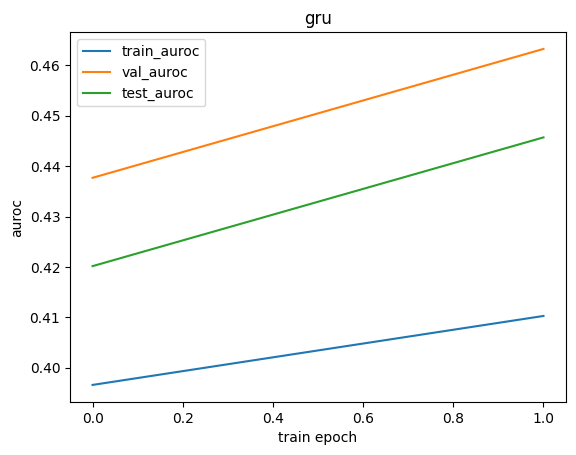

In [9]:
train_gru(50, 0.2, 0.0001, 1, 8)

## GRU-D

In [4]:
def train_grud(hid_dim, dropout, lr, max_epochs,gradient_accumulation_steps):
    #set up
    parser = parse_args(model_type='grud',hid_dim =hid_dim,dropout = dropout, lr = lr, max_epochs = max_epochs, gradient_accumulation_steps = gradient_accumulation_steps)
    args, _ = parser.parse_known_args()
    set_all_seeds(args.seed+int(args.run.split('o')[0]))
    set_output_dir(args)
    args.logger = Logger(args.output_dir, 'log.txt')
    args.logger.write('\n'+str(args))
    dataset = Dataset(args)
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_mapping[args.model_type](args)
    model.to(args.device)
    results = {'epoch':[],'train_auroc':[],'val_auroc':[],'test_auroc':[]}

    #trainning
    num_train = len(dataset.splits['train'])
    args.logger.write('\nSize of training data: ' + str(num_train))
    num_batches_per_epoch = num_train/args.train_batch_size
    args.logger.write('\nNo. of training batches per epoch: '
                      +str(num_batches_per_epoch))
    args.max_steps = int(round(num_batches_per_epoch)*args.max_epochs)
    args.logger.write('\nMax steps: ' + str(num_batches_per_epoch))

    if args.validate_every is None:
        args.validate_every = int(np.ceil(num_batches_per_epoch)) #validate after each batch

    num_steps = 0
    optimizer = AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=args.lr)
    train_bar = tqdm(range(args.max_steps))
    evaluator = Evaluator(args)

    #before training, calculate metrics
    if args.validate_after<0:
        res_val = evaluator.evaluate(model, dataset, 'val',  train_step=-1)
        res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=-1)
        res_test = evaluator.evaluate(model, dataset, 'test', train_step=-1)
        results['train_auroc'].append(res_train['auroc'])
        results['val_auroc'].append(res_val['auroc'])
        results['test_auroc'].append(res_test['auroc'])

    #training
    model.train()
    for step in train_bar:
        data_batch = dataset.get_batch()
        data_batch = {k:v.to(args.device) for k,v in data_batch.items()}

        loss = model(**data_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.3)
        if (step+1)%args.gradient_accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()

        num_steps += 1

        # run validatation
        if (num_steps>=args.validate_after) and (num_steps%args.validate_every==0):
            # get metrics on test and validation splits
            res_val = evaluator.evaluate(model, dataset, 'val', train_step=step)
            res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=step)
            res_test = evaluator.evaluate(model, dataset, 'test', train_step=step)
            results['train_auroc'].append(res_train['auroc'])
            results['val_auroc'].append(res_val['auroc'])
            results['test_auroc'].append(res_test['auroc'])
            model.train(True)

    results['epoch'] =list(range(0,args.max_epochs+1))
    save_results(args, results)

In [ ]:
train_grud(60, 0.2, 0.0001, 1, 8)

## STraTS

In [4]:
def train_strats(hid_dim,num_heads,lr,max_epochs,gradient_accumulation_steps):
    #set up
    parser = parse_args(model_type='strats',hid_dim=hid_dim,num_heads=num_heads,lr=lr,max_epochs = max_epochs,gradient_accumulation_steps =gradient_accumulation_steps)
    args, _ = parser.parse_known_args()
    set_all_seeds(args.seed+int(args.run.split('o')[0]))
    set_output_dir(args)
    args.logger = Logger(args.output_dir, 'log.txt')
    args.logger.write('\n'+str(args))
    dataset = Dataset(args)
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_mapping[args.model_type](args)
    model.to(args.device)
    results = {'epoch':[],'train_auroc':[],'val_auroc':[],'test_auroc':[], 
                                'embedding_weights':None, 'shap_values':None}

    #trainning
    num_train = len(dataset.splits['train'])
    args.logger.write('\nSize of training data: ' + str(num_train))
    num_batches_per_epoch = num_train/args.train_batch_size
    args.logger.write('\nNo. of training batches per epoch: '
                      +str(num_batches_per_epoch))
    args.max_steps = int(round(num_batches_per_epoch)*args.max_epochs)
    args.logger.write('\nMax steps: ' + str(num_batches_per_epoch))

    if args.validate_every is None:
        args.validate_every = int(np.ceil(num_batches_per_epoch)) #validate after each batch

    num_steps = 0
    optimizer = AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=args.lr)
    train_bar = tqdm(range(args.max_steps))
    evaluator = Evaluator(args)

    #before training, calculate metrics
    if args.validate_after<0:
        res_val = evaluator.evaluate(model, dataset, 'val',  train_step=-1)
        res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=-1)
        res_test = evaluator.evaluate(model, dataset, 'test', train_step=-1)
        results['train_auroc'].append(res_train['auroc'])
        results['val_auroc'].append(res_val['auroc'])
        results['test_auroc'].append(res_test['auroc'])

    #training
    model.train()
    for step in train_bar:
        data_batch = dataset.get_batch()
        data_batch = {k:v.to(args.device) for k,v in data_batch.items()}

        loss = model(**data_batch)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.3)
        if (step+1)%args.gradient_accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()

        num_steps += 1

        # run validatation
        if (num_steps>=args.validate_after) and (num_steps%args.validate_every==0):
            # get metrics on test and validation splits
            res_val = evaluator.evaluate(model, dataset, 'val', train_step=step)
            res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=step)
            res_test = evaluator.evaluate(model, dataset, 'test', train_step=step)
            results['train_auroc'].append(res_train['auroc'])
            results['val_auroc'].append(res_val['auroc'])
            results['test_auroc'].append(res_test['auroc'])
            model.train(True)

    results['epoch'] =list(range(0,args.max_epochs+1))
    save_results(args, results)


In [ ]:
train_strats(hid_dim=32,num_heads=4,lr=0.0005,max_epochs = 1,gradient_accumulation_steps=1)

## Test new models

In [5]:
def train_new(hid_dim,num_heads,lr,max_epochs,gradient_accumulation_steps):
    #set up
    parser = parse_args(model_type='new',hid_dim=hid_dim,num_heads=num_heads,lr=lr,max_epochs=max_epochs,gradient_accumulation_steps =gradient_accumulation_steps)
    args, _ = parser.parse_known_args()
    set_all_seeds(args.seed+int(args.run.split('o')[0]))
    set_output_dir(args)
    args.logger = Logger(args.output_dir, 'log.txt')
    args.logger.write('\n'+str(args))
    dataset = Dataset(args)
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model_mapping[args.model_type](args)
    model.to(args.device)
    results = {'epoch':[],'train_auroc':[],'val_auroc':[],'test_auroc':[]}

    #trainning
    num_train = len(dataset.splits['train'])
    args.logger.write('\nSize of training data: ' + str(num_train))
    num_batches_per_epoch = num_train/args.train_batch_size
    args.logger.write('\nNo. of training batches per epoch: '
                      +str(num_batches_per_epoch))
    args.max_steps = int(round(num_batches_per_epoch)*args.max_epochs)
    args.logger.write('\nMax steps: ' + str(num_batches_per_epoch))

    if args.validate_every is None:
        args.validate_every = int(np.ceil(num_batches_per_epoch)) #validate after each batch

    num_steps = 0
    optimizer = AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=args.lr)
    train_bar = tqdm(range(args.max_steps))
    evaluator = Evaluator(args)

    #before training, calculate metrics
    if args.validate_after<0:
        res_val = evaluator.evaluate(model, dataset, 'val',  train_step=-1)
        res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=-1)
        res_test = evaluator.evaluate(model, dataset, 'test', train_step=-1)
        results['train_auroc'].append(res_train['auroc'])
        results['val_auroc'].append(res_val['auroc'])
        results['test_auroc'].append(res_test['auroc'])

    #training
    model.train()
    for step in train_bar:
        data_batch = dataset.get_batch()
        data_batch = {k:v.to(args.device) for k,v in data_batch.items()}

        loss = model(**data_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.3)
        if (step+1)%args.gradient_accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()

        num_steps += 1

        # run validatation
        if (num_steps>=args.validate_after) and (num_steps%args.validate_every==0):
            # get metrics on test and validation splits
            res_val = evaluator.evaluate(model, dataset, 'val', train_step=step)
            res_train = evaluator.evaluate(model, dataset, 'eval_train', train_step=step)
            res_test = evaluator.evaluate(model, dataset, 'test', train_step=step)
            results['train_auroc'].append(res_train['auroc'])
            results['val_auroc'].append(res_val['auroc'])
            results['test_auroc'].append(res_test['auroc'])
            model.train(True)

    results['epoch']=list(range(0,args.max_epochs+1))
    save_results(args, results)


In [ ]:
train_new(hid_dim=32,num_heads=4,lr=0.0005,max_epochs=1,gradient_accumulation_steps=8)